## Imports

In [37]:
from llama_index import download_loader, SimpleDirectoryReader
from ragas.testset import TestsetGenerator
from llama_index import download_loader

import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

In [30]:
import matplotlib.pyplot as plt

## Assessing current state of test date generation

In [5]:

ArxivReader = download_loader("ArxivReader")

loader = ArxivReader() #uses simpledirectory reader under the hood, hence need modification to laod pages properly

In [6]:
documents = loader.load_data("abs:large language models+AND+abs:prompting",max_results=50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 3.2 MB/s eta 0:00:00m eta 0:00:0136m0:00:01


In [25]:
print(documents[12].get_metadata_str())
print("CONTENT")
print(documents[14].get_content())
print(len(documents[14].get_content().split(' ')))

page_label: 13
file_name: 00d01c73021a6de9f664caf7d4528b25.pdf
Title of this paper: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Date published: 06/12/2023
URL: http://arxiv.org/abs/2306.07377v1
CONTENT
Large Language Models in Non-English Content Analysis15
Models are expensive to initially train, but once built, their representations are relatively 
cheap to use and be fine-tuned for different tasks. Thus, many technologists simply 
use pretrained large language models built by others (usually large companies, with the 
expertise and resources) instead of paying to create their own. The few big pretrained 
models that exist have thus become a sort of infrastructure, known as “foundation 
models” (Bommasani et al., 2021 ). This gives many technologists access to the state of 
the art capabilities, but it also creates a single point of failure for the sector as a whole: 
if a foundation model has a problem, it will p

(array([ 79., 130., 166., 205., 237.,  59.,  27.,   3.,   4.,   1.]),
 array([   0. ,  150.8,  301.6,  452.4,  603.2,  754. ,  904.8, 1055.6,
        1206.4, 1357.2, 1508. ]),
 <BarContainer object of 10 artists>)

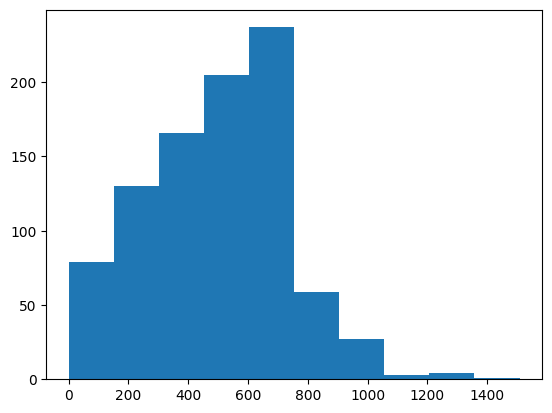

In [31]:
plt.hist([len(doc.get_content().split()) for doc in documents])

In [3]:
test_dist =  {
    "simple": 0.3,
    "reasoning": 0.25,
    "multi_context": 0.25,
    "conditional": 0.2,
}

In [4]:
testsetgenerator = TestsetGenerator.from_default(testset_distribution=test_dist,chunk_size=1024)


In [8]:
test_size = 25
testset = testsetgenerator.generate(documents, test_size=test_size)
test_df = testset.to_pandas()
test_df.head()

  0%|                                                            | 0/25 [00:00<?, ?it/s]

{'score': True, 'is_table_present': False}
seed question What are the limitations of LOGIC -LM?
{'score': True, 'is_table_present': True}
seed question What are the four broader application areas of LLMs investigated in the included studies?
{'score': True, 'is_table_present': False}
seed question How do we propose to attack the detectors?
{'score': True, 'is_table_present': True}
seed question What is the metric type for the task "Knowledge Question Answering" in the Legal Knowledge Memorization category?



KeyboardInterrupt



In [ ]:
test_df.to_csv("arxiv_questions_v3.csv")

**Observations**
- Conditional question evol is working
- reasoning/multi context are not working as expected
- Almost all questions are closed endeded 
- Almost all questions start with "What"

## Experiments

In [32]:
from llama_index.readers.file.markdown_reader import MarkdownReader
from llama_index.schema import Document
from typing import List, Dict, Optional
from pathlib import Path
import re
import os

In [87]:
class RagasMdReader(MarkdownReader):
    
    @staticmethod
    def get_file_metadata(path):
        
        return {"filename":os.path.basename(path),
                "dirname":os.path.dirname(path)}
        
    
    def get_local_metadata(self, text):
        
#         hyperlinks = {}
#         pattern = r"\[(.*?)\]\((?!https)(.*?)\)"
#         for k,v in re.findall(pattern, text):
#             if 'http' not in v and len(k.split())<=3 and v.split('/')[-1].startswith('#'):
#                 hyperlinks[k] = v
#         return hyperlinks
        return_dict = {}
        pattern = r'---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'
        match = re.findall(pattern, text)
        if match:
            title,desc = match[0]
            return_dict['title'] = title
            return_dict['description'] = desc if desc else None
            
        return return_dict

        
    
        
    
    def load_data(
        self, file: Path, extra_info: Optional[Dict] = None
    ) -> List[Document]:
        """Parse file into string."""
        
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
        if self._remove_hyperlinks:
            content = self.remove_hyperlinks(content)
        if self._remove_images:
            content = self.remove_images(content)
            
        local_metadata = self.get_local_metadata(content)

        extra_info = dict(extra_info,**local_metadata) if local_metadata else {}
        return [Document(text=text,metadata=extra_info)]
        
        


In [88]:
md_reader = RagasMdReader(remove_hyperlinks=False)

In [89]:
def llm2(prompt, **kwargs):
    response = openai.ChatCompletion.create(
        model=kwargs.get("model", "gpt-4"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response

In [90]:
from ragas.testset.prompts import SEED_QUESTION, EVOLUTION_ELIMINATION

In [91]:
dirs = [
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/leadership/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/company/",
]
documents = []
for dir_path in dirs:
    loader = SimpleDirectoryReader(dir_path, 
                                   recursive=True,
                                  file_extractor={".md":md_reader},
                                file_metadata=RagasMdReader.get_file_metadata)
    
    documents.extend(loader.load_data())

In [101]:
print(documents[14].metadata['title'])

Understanding SOCIAL STYLES


In [78]:
import re

# Sample text
text = """
---
title: "Ask Me Anything"
description: "Learn and ask questions at GitLab's Ask Me Anything (AMA) meetings"
---
"""

# Regular expression to capture title and description
pattern_optional_description = '---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'

# Finding matches
matches = re.match(pattern_optional_description, text)

matches


In [79]:
matches is None

True

In [72]:
pattern = re.compile('---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---')
[m.groupdict() for m in pattern.finditer(text)]

[{}]

In [68]:
text = """
---
title: "Book clubs"
---

From time to time, we run internal book clubs on a book from one of our resource lists. All are welcome! However,
each club has a suggested audience to indicate roles to which the content is tailored.

- [Leadership]({{< ref "_index.md#books" >}})
- [Development](https://about.gitlab.com/handbook/engineering/development/#books)
"""

In [60]:
pattern_optional_description = r'---\s*title:\s*"(.+?)"\s*---'
re.findall(pattern,text)

[]

In [46]:
print(documents[4].get_content())



Better Onboarding

- Dates: 2021-07-08 and 2021-07-15
- Time: 02:00 PM UTC
- Zoom (password is in the calendar event info)
- Meeting agenda
- Discussion issue
- Recording Session 1
- Recording Session 2
- Suggested audience: Growth, Product, Product Design and Development




Trustworthy Online Controlled Experiments (A Practical Guide to A/B Testing)

- Dates: 2021-03-11 to 2021-06-10 (every week)
- Time: 08:00 PT / 15:00 UTC
- Zoom (password is in the calendar event info)
- Meeting agenda
- Discussion issue
- Suggested audience: growth, product & engineering




Ruby under a Microscope

- Dates: 2020-11-24 to 2021-03-03 (every week)
- Time: EMEA 14:00 UTC, AMER/APAC 23:00 UTC
- Zoom EMEA, Zoom AMER/APAC (password is in the calendar event info)
- Meeting agenda
- Discussion issue
- Suggested audience: engineering




Software Engineering at Google

- Dates: 2020-05-20 to 2020-07-29 (every 2 weeks)
- Time: 21:30 UTC
- Zoom
- Meeting agenda
- Discussion issue
- Suggested audience: eng

In [39]:
len(documents)

168

In [13]:
# documents[0].metadata

In [12]:
testset = testsetgenerator.generate(documents, test_size=50)


  0%|                                                            | 0/50 [00:00<?, ?it/s]

{'score': True, 'is_table_present': False}
seed question What are some strategies to build influence in the workplace?


  2%|█                                                   | 1/50 [00:42<34:59, 42.85s/it]/Users/shahules/belar/src/ragas/testset/testset_generator.py:302: UserWarning: No neighbors exists
  warnings.warn("No neighbors exists")


{'score': True, 'is_table_present': True}
seed question Who is the facilitator of the expense management working group?
{'score': True, 'is_table_present': False}
seed question What is the first phase of the three year strategy process?
{'score': True, 'is_table_present': False}
seed question What is GitLab's strategic goal?


  6%|███                                                 | 3/50 [01:17<18:45, 23.94s/it]

{'score': True, 'is_table_present': False}
seed question What functionality aligns with the reporter permission access in GitLab?


 12%|██████▏                                             | 6/50 [01:45<11:02, 15.06s/it]

{'score': True, 'is_table_present': True}
seed question Who is the Executive Sponsor of the MLOps Working Group?
{'score': True, 'is_table_present': False}
seed question What is the advantage of a functional organization structure?
{'score': True, 'is_table_present': True}
seed question What are the benefits reported by people at high trust companies compared to those at low trust companies, according to a study from Accenture?
{'score': True, 'is_table_present': False}
seed question What are the different scopes for caching available?


 20%|██████████▏                                        | 10/50 [02:43<09:48, 14.72s/it]

{'score': True, 'is_table_present': False}
seed question How does using our own product help us improve GitLab?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the OKR Draft Review Meeting?
{'score': True, 'is_table_present': False}
seed question What factors will GitLab consider when assessing the viability of location-based pricing?
{'score': True, 'is_table_present': True}
seed question Who is the DRI for developing and implementing a communication plan for the working group?
{'score': True, 'is_table_present': True}
seed question Who is the Facilitator of the Working Group?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the Quote-to-Cash (Q2C) process?
{'score': True, 'is_table_present': True}
seed question What are the advantages of a single application in GitLab's flywheel strategy?
{'score': True, 'is_table_present': False}
seed question What is the goal of the Functional Leaders Meeting?
{'score': True, 'is_table_

 30%|███████████████▎                                   | 15/50 [05:33<14:04, 24.12s/it]

{'score': True, 'is_table_present': True}
seed question What are the exit criteria for the project?
{'score': True, 'is_table_present': True}
seed question What is the end date for the project?
{'score': True, 'is_table_present': False}
seed question Why does GitLab intentionally not implement "20% time" for contributing to open source projects?
{'score': True, 'is_table_present': False}
seed question What measures can GitLab take to address the impact of a pandemic?


 42%|█████████████████████▍                             | 21/50 [06:17<07:58, 16.51s/it]

{'score': True, 'is_table_present': False}
seed question What was the response rate for the survey sent to churned GitLab.com users?
{'score': True, 'is_table_present': False}
seed question Who is responsible for scheduling and coordinating the OKR process at GitLab?
{'score': True, 'is_table_present': False}
seed question What is the reasoning behind the amount of free credits offered?
{'score': True, 'is_table_present': True}
seed question What is the purpose of the working group mentioned in the context?
{'score': True, 'is_table_present': False}
seed question What should I review before compensation conversations at GitLab?
{'score': True, 'is_table_present': True}
seed question What is the meeting schedule for the Emerging Talent program?
{'score': True, 'is_table_present': False}
seed question Who needs to approve the creation of a single-engineer group?
{'score': True, 'is_table_present': False}
seed question What is the recommended order to go through the agenda?
{'score': True

 56%|████████████████████████████▌                      | 28/50 [07:30<05:04, 13.84s/it]

{'score': True, 'is_table_present': False}
seed question What are some strategies for leading teams through challenging times?
{'score': True, 'is_table_present': False}
seed question What is the purpose of our Mission at GitLab?
{'score': True, 'is_table_present': False}
seed question What is the purpose of implementing caching in order to reduce database overhead?


 72%|████████████████████████████████████▋              | 36/50 [08:04<02:18,  9.88s/it]

{'score': True, 'is_table_present': False}
seed question What are the responsibilities of a Support Engineer in incident management?


 90%|█████████████████████████████████████████████▉     | 45/50 [08:30<00:35,  7.12s/it]

{'score': True, 'is_table_present': False}
seed question Why should we consider open-sourcing a feature?
{'score': True, 'is_table_present': False}
seed question What measures are taken to address the concern of key people leaving the company?
{'score': True, 'is_table_present': False}
seed question What is GitLab's purpose?


55it [09:35,  6.86s/it]                                                                 

{'score': True, 'is_table_present': True}
seed question What measures has GitLab taken to address the concern of an economic downturn and the impact of a pandemic like COVID-19?
{'score': True, 'is_table_present': False}
seed question What are the principles for achieving fault-tolerance in GitLab?


66it [10:11,  5.49s/it]

{'score': True, 'is_table_present': False}
seed question What are the criteria for Key Results?
{'score': True, 'is_table_present': False}
seed question What were the challenges faced during the quarter?
{'score': True, 'is_table_present': True}
seed question What are some strategies to potentially apply when working with an Expressive?
{'score': True, 'is_table_present': True}
seed question What are the potential tools/services that other companies are using for event stream implementation?


78it [10:54,  4.78s/it]

{'score': True, 'is_table_present': True}
seed question What is the status of the proposed fixes for each identified low effort high risk item in the Token Management Working Group?
{'score': True, 'is_table_present': False}
seed question What are some examples of the compromising method in conflict resolution?


91it [11:23,  3.87s/it]

{'score': True, 'is_table_present': False}
seed question What is the process for addressing underperformance in senior leadership roles?


105it [12:05,  3.56s/it]

{'score': True, 'is_table_present': False}
seed question What are some strategies to build influence in the workplace?


120it [12:40,  3.11s/it]

{'score': True, 'is_table_present': False}
seed question What are the characteristics of the Analytical style?
{'score': True, 'is_table_present': False}
seed question What is the communication flow at GitLab?


136it [13:16,  2.82s/it]

{'score': True, 'is_table_present': False}
seed question What was the purpose of transitioning GitLab Pages from NFS to Object Storage?
{'score': True, 'is_table_present': False}
seed question What are some reasons that career development conversations are important?


153it [13:52,  2.57s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of M-teams at GitLab?


171it [14:06,  1.94s/it]

{'score': True, 'is_table_present': True}
seed question How can division OKRs be aligned to CEO OKRs in cascading OKR methodology?


190it [14:29,  1.71s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of Stage 5 in the team development process?
{'score': True, 'is_table_present': True}
seed question What is the goal for reducing churn and contraction in comparison to FY23-Q4?
{'score': True, 'is_table_present': False}
seed question What are the two flywheel strategies of GitLab?
{'score': True, 'is_table_present': False}
seed question What is the estimated cost per connection for the real-time feature?
{'score': True, 'is_table_present': False}
seed question What were the results of our targeted OKR's?
{'score': True, 'is_table_present': True}
seed question Who is the Executive Sponsor of the Working Group?
{'score': True, 'is_table_present': True}
seed question What is the task scheduled for the week of 2022-07-11 in the OKR schedule?
{'score': True, 'is_table_present': False}
seed question What is the purpose of coaching at GitLab?
{'score': True, 'is_table_present': False}
seed question What is GitLab's 

210it [15:47,  2.45s/it]

{'score': True, 'is_table_present': False}
seed question What are some strategies for having effective crucial conversations in an all-remote environment?


231it [16:15,  2.07s/it]

{'score': True, 'is_table_present': False}
seed question What are the expectations for members of the management group?
{'score': True, 'is_table_present': False}
seed question What is the principle of "Fast follower" in our company?
{'score': True, 'is_table_present': False}
seed question What are the industry trends that limit infrastructure bundling?
{'score': True, 'is_table_present': False}
seed question What are some reasons that managers may avoid career development conversations?


253it [17:20,  2.36s/it]

{'score': True, 'is_table_present': True}
seed question Who is the DRI for developing and implementing a communication plan for the working group?
{'score': True, 'is_table_present': False}
seed question What is the progress of optimizing frontend code for larger projects?
{'score': True, 'is_table_present': True}
seed question What is the chosen technology for implementing real-time features in GitLab?


276it [17:57,  2.12s/it]

{'score': True, 'is_table_present': True}
seed question What is the purpose of the CustomersDot BillingAccount management?
{'score': True, 'is_table_present': True}
seed question What is the target end date for the product development flow?
{'score': True, 'is_table_present': True}
seed question What programming languages are used by the AI Model Validation group at GitLab?


300it [18:55,  2.21s/it]

{'score': True, 'is_table_present': False}
seed question What are the advantages of having a single plan for one customer?


325it [19:11,  1.70s/it]

{'score': True, 'is_table_present': True}
seed question What is the Recovery Point Objective (RPO) in the context of the Disaster Recovery Working Group?
{'score': True, 'is_table_present': True}
seed question Who is the DRI (Directly Responsible Individual) for the Contributor Success functional role?
{'score': True, 'is_table_present': False}
seed question What is the recommended approach for discussing promotions and salary increases?
{'score': True, 'is_table_present': False}
seed question What is the purpose of GitLab?


351it [20:08,  1.86s/it]

{'score': True, 'is_table_present': False}
seed question What questions might team members ask during a career development conversation?


378it [20:26,  1.47s/it]

{'score': True, 'is_table_present': True}
seed question What are the learning objectives of the One Week Challenge?
{'score': True, 'is_table_present': False}
seed question What are the characteristics of time-decay data?


406it [21:11,  1.51s/it]

{'score': True, 'is_table_present': False}
seed question What are the responsibilities of Functional Leaders after the meeting?
{'score': True, 'is_table_present': False}
seed question How can I participate in an active working group?
{'score': True, 'is_table_present': True}
seed question What is the target end date for the implementation of the data pipeline?
{'score': True, 'is_table_present': True}
seed question What is the CEO KR for improving user engagement?
{'score': True, 'is_table_present': False}
seed question How does open source benefit from open core?


435it [22:30,  1.91s/it]

{'score': True, 'is_table_present': False}
seed question What are the steps for organizational alignment in workforce planning?


465it [23:08,  1.70s/it]

{'score': True, 'is_table_present': True}
seed question What is the role of Christopher Lefelhocz in the Sharding Working Group?
{'score': True, 'is_table_present': True}
seed question How are upcoming Family and Friends Days determined at GitLab?
{'score': True, 'is_table_present': False}
seed question What is the purpose of a Performance Improvement Plan (PIP)?


496it [23:55,  1.64s/it]

{'score': True, 'is_table_present': True}
seed question What is the future target plan feature that will be introduced to all stages in Q4?
{'score': True, 'is_table_present': False}
seed question What is the preferred option to address underperformance?
{'score': True, 'is_table_present': True}
seed question What is the CEO's objective for reducing churn and contraction?
{'score': True, 'is_table_present': False}
seed question What is the purpose of organizing informal communications at GitLab?


528it [24:40,  1.57s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of GitLab Onsites?
{'score': True, 'is_table_present': False}
seed question Why should we charge more for SaaS compared to self-managed?


HTTPSConnectionPool(host='api.smith.langchain.com', port=443): Read timed out. (read timeout=7.0)


{'score': True, 'is_table_present': False}
seed question Why does GitLab not implement "20% time" for contributing to open source projects?
{'score': True, 'is_table_present': False}
seed question What are the different methods for managing conflict?


561it [25:53,  1.77s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of the AMA?
{'score': True, 'is_table_present': True}
seed question What is the business viability of the proposed solution to simplify the organizational model in GitLab?
{'score': True, 'is_table_present': True}
seed question What is the relationship between departments and sub-departments in the organizational structure at GitLab?
{'score': True, 'is_table_present': False}
seed question What should DRIs do to make decisions at GitLab?
{'score': True, 'is_table_present': False}
seed question Why are career development conversations important for managers?


595it [27:16,  1.99s/it]

{'score': True, 'is_table_present': False}
seed question What are the three factors that distinguish a crucial conversation?
{'score': True, 'is_table_present': False}
seed question Question: 
What are the advantages of GitLab's all-remote workforce?
{'score': True, 'is_table_present': False}
seed question Why do managers resist delegating tasks?


630it [28:04,  1.79s/it]

{'score': True, 'is_table_present': False}
seed question What is the industry standard for Mean Time To Remediation for security vulnerabilities?
{'score': True, 'is_table_present': False}
seed question What is the purpose of Stage 7 in the team development process?
{'score': True, 'is_table_present': False}
seed question What are the traits of high-performing teams at GitLab?


666it [29:04,  1.75s/it]

{'score': True, 'is_table_present': True}
seed question What is the role of Kamil Trzciński in the working group?
{'score': True, 'is_table_present': False}
seed question What is the recommended order to go through the agenda?
{'score': True, 'is_table_present': True}
seed question What is the target end date for the accessibility checks implementation in GitLab feature specs and UI components codebase?
{'score': True, 'is_table_present': False}
seed question What is the preferred option to address underperformance?
{'score': True, 'is_table_present': True}
seed question What is the progress of building a transient test pipeline to detect transient bugs?
{'score': True, 'is_table_present': True}
seed question What is the target end date for the Customer Use Case Adoption working group?
{'score': True, 'is_table_present': False}
seed question What is the purpose of an onsite for all-remote teams?


703it [30:16,  1.81s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of regularly scheduled 1-1 meetings in performance management?


741it [30:34,  1.38s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of the Drexler-Sibbet model in product group learning sessions?
{'score': True, 'is_table_present': True}
seed question What is the price per user per month for the Premium tier in the Self-Managed/SaaS pricing model?
{'score': True, 'is_table_present': False}
seed question What is the Building High Performing Teams model?


780it [31:43,  1.51s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of the Job Frameworks?
{'score': True, 'is_table_present': False}
seed question What is the goal of the "Grow Careers" section in the GitLab strategy?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the Manager Transition Meeting?
{'score': True, 'is_table_present': False}
seed question Why does GitLab use a hybrid sales model?
{'score': True, 'is_table_present': False}
seed question How can new objectives be added in GitLab?


820it [32:34,  1.43s/it]

{'score': True, 'is_table_present': True}
seed question How should teams update the score for their key results in GitLab?


861it [32:56,  1.15s/it]

{'score': True, 'is_table_present': True}
seed question What is the description of the "Fulfillment Efficiency" top cross-functional initiative?
{'score': True, 'is_table_present': True}
seed question What is the goal of the working group mentioned in the context?
{'score': True, 'is_table_present': False}
seed question What is the current failure rate of system failures in CI/CD?
{'score': True, 'is_table_present': True}
seed question What is the task scheduled for the week of 2021-01-11 in the OKR schedule?
{'score': True, 'is_table_present': False}
seed question What is the purpose of a PIP in the performance improvement process?


903it [33:55,  1.23s/it]

{'score': True, 'is_table_present': False}
seed question What is the importance of self-awareness in developing emotional intelligence?


946it [34:21,  1.03s/it]

{'score': True, 'is_table_present': True}
seed question Who is the facilitator of the Working Group?
{'score': True, 'is_table_present': True}
seed question Who is the DRI for defining the vision of the GitLab API for the future years?
{'score': True, 'is_table_present': False}
seed question What is the purpose of skip-level meetings?


990it [35:10,  1.06s/it]

{'score': True, 'is_table_present': True}
seed question What is the meeting schedule for the GitLab AI Integration Working Group?
{'score': True, 'is_table_present': False}
seed question Why did GitLab become an all-remote company?


1035it [35:56,  1.05s/it]

{'score': True, 'is_table_present': True}
seed question What are the exit criteria for the sharding working group?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the Job Frameworks at GitLab?


1081it [36:38,  1.01s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of hosting a "Lunch & Learn"?


1128it [37:01,  1.19it/s]

{'score': True, 'is_table_present': True}
seed question What is the progress status of Step 1 in the process of creating a standardized prioritization framework?
{'score': True, 'is_table_present': False}
seed question What is the role of a member in a Working Group?


1176it [37:24,  1.38it/s]

{'score': True, 'is_table_present': True}
seed question What were the main areas of improvement identified by the working group in the Object Storage implementation?
{'score': True, 'is_table_present': True}
seed question Who is the Triage Lead in the Working Group?
{'score': True, 'is_table_present': True}
seed question What is the due date for the "Definition of the objects" phase in the roadmap?
{'score': True, 'is_table_present': False}
seed question What is the purpose of adding new models to the CustomersDot data architecture?
{'score': True, 'is_table_present': True}
seed question What is the target end date for the GitHost migration?
{'score': True, 'is_table_present': True}
seed question Who is the Senior Director of Development in the Working Group?
{'score': True, 'is_table_present': True}
seed question What tasks are still outstanding at the time of closing this Working Group?
{'score': True, 'is_table_present': True}
seed question What is the role of Farnoosh Seifoddini in

1225it [40:29,  1.69s/it]

{'score': True, 'is_table_present': False}
seed question What is the role of a leader at GitLab in building high-performing teams?


1275it [40:55,  1.93s/it]


In [13]:
testset.to_pandas().to_csv("gitlab_communication_company_v2.csv")

In [23]:
testset.to_pandas()

,seed_question,question,context,answer,question_type,episode_done,evolution_elimination
0,What are some strategies to build influence in...,How can communication patterns be utilized to ...,"- ""During a crucial conversation, different pr...",Communication patterns can be utilized to buil...,conditional,False,False
1,What are the strategic goals of GitLab?,What is GitLab's strategic goal to become the ...,- Along the road to realizing our mission of e...,GitLab's strategic goal to become the leading ...,reasoning,True,False
2,What functionality aligns with the reporter pe...,Which GitLab permission allows for managing la...,The main functionality that some non-developer...,The GitLab permission that allows for managing...,reasoning,True,False
3,What are the different scopes for caching avai...,What are the different caching scopes availabl...,"1. ""In order to reduce the database overhead, ...",The different caching scopes available for red...,conditional,False,False
4,What is the purpose of the Quote-to-Cash process?,What is the purpose of the Quote-to-Cash proce...,- An efficient Quote-to-Cash system makes purc...,The purpose of the Quote-to-Cash process is to...,multi_context,True,False
5,Who is responsible for running meetings in a w...,Who facilitates meetings and ensures operation...,- A facilitator is responsible for running mee...,The facilitator is responsible for running mee...,multi_context,True,False
6,What are some suggested team building activiti...,What team building activities can be used to b...,"- ""It's great for building trust, getting to k...",Some team building activities that can be used...,multi_context,True,True
7,What is the impact of elevating the caching le...,What is the impact of implementing a per-proce...,- When we started to cache license information...,The impact of implementing a per-process memor...,reasoning,True,True
8,What should I review before compensation conve...,What should I review before compensation conve...,- Conversations with regards to compensation a...,"Before compensation conversations at GitLab, y...",simple,True,None
9,What is the objective of establishing a repeat...,What is the objective of establishing a repeat...,- We aim to create a working group to establis...,The objective of establishing a repeatable pro...,simple,True,None


In [20]:
q1="How should I use my notification settings in Slack?"
q2="What's the best way to manage Slack notification settings for efficient communication and minimal disruptions?"


In [21]:
prompt = EVOLUTION_ELIMINATION.prompt.template.format(question1=q1, question2=q2)

In [22]:
llm2(prompt)

<OpenAIObject chat.completion id=chatcmpl-8JFEQOhc3FPRQ6hhpviDo4mVdSD9G at 0x7f944a3f65c0> JSON: {
  "id": "chatcmpl-8JFEQOhc3FPRQ6hhpviDo4mVdSD9G",
  "object": "chat.completion",
  "created": 1699597474,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\n  \"reason\": \"Both questions are asking about managing notification settings in Slack, but the second question adds additional requirements of efficient communication and minimal disruptions, which changes the depth of the inquiry.\",\n  \"verdict\": \"Not Equal\"\n}"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 212,
    "completion_tokens": 49,
    "total_tokens": 261
  }
}

## Create multi context
- find similar docs using metadata 


In [116]:
from langchain.embeddings import OpenAIEmbeddings
from llama_index.indices.query.embedding_utils import get_top_k_embeddings

In [103]:
model = OpenAIEmbeddings()

In [112]:
titles = [doc.metadata.get('title').strip('"') for doc in documents if doc.metadata]

In [114]:
embeddings = model.embed_documents(titles)

In [170]:
k=24

In [171]:
scores, indices = get_top_k_embeddings(embeddings[k],embeddings,similarity_cutoff=0.8)

In [172]:
print(f"Seach query :{titles[k]}\n Results: [{[titles[i] for i in indices[:5]]}")

Seach query :Top Cross-Functional Initiatives
 Results: [['Top Cross-Functional Initiatives', 'Building High Performing Teams', 'Product Career Development Framework Working Group', 'Leadership', 'Single Codebase Working Group']
